# Project Assignment - Image Classification Exploiting Sparsity

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 1.58 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.12 environment at: /usr
Resolved 180 packages in 1.53s
Prepared 41 packages in 46.26s
Uninstalled 31 packages in 896ms
Installed 41 packages in 462ms
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.4
 + cuda-pathfinder==1.3.1
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.4
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl)
 + cudf-cu12==25.8.0
 + cugraph-cu12==25.8.0
 - cuml-cu12==25.6.0
 + cuml-cu12==25.8.0
 - cuvs-cu12==25.6.1
 + cuvs-cu12==25.8.0
 + cu

In [2]:
%load_ext cuml.accel

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from math import isclose
from sklearn.metrics import mean_squared_error, r2_score

## Data Preparation

In [4]:
# reading data and converting to dataframe
data = pd.read_csv('Project_Data_EE4C12_CE_IMG.csv', header=None)

In [5]:
data

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8038,5,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8039,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8040,6,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8041,6,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# dropping row with missing values
data.drop([8042], inplace=True)

In [7]:
data

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8037,8,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8038,5,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8039,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8040,6,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# separating features and labels
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values
X = X / 255.0

In [9]:
# function to display image from flattened array (784 -> 28x28)
def create_image(flatImage,imageSize=28):
    image = np.zeros((imageSize,imageSize))
    for i in range(imageSize):
        image[i] = flatImage[(i*imageSize):((i+1)*imageSize)]
    return image

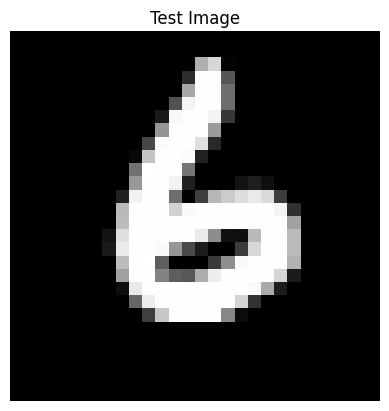

In [10]:
test_image =create_image(X[-1])
plt.imshow(test_image, cmap='gray')  # 'gray' ensures it's displayed in grayscale
plt.title("Test Image")
plt.axis('off')  # Hide axes for clarity
plt.show()

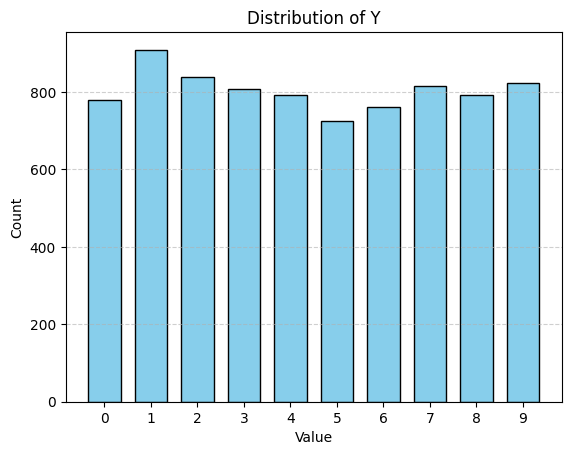

In [11]:
# plotting the amount of samples for each label:
unique, counts = np.unique(y, return_counts=True)
bar_width = 0.7  # smaller value = more space between bars
plt.bar(unique, counts, width=bar_width, color='skyblue', edgecolor='black')
plt.title("Distribution of Y")
plt.xlabel("Value")
plt.ylabel("Count")
plt.xticks(unique)  # Show each integer on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.savefig("data_histogram.png")
plt.show()

In [12]:
random_state = 42

In [13]:
# creating test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=random_state, stratify=y
)

In [14]:
# creating training and validation tests
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=random_state, stratify=y_temp
)

In [15]:
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 5632
Validation set size: 1203
Test set size: 1207


### Functions for Random Sampling, Variance-Based Sampling of Features

In [16]:
def select_features_random(random_state, n_features):
    np.random.seed(random_state)
    selected_features = np.random.choice(784, size=n_features, replace=False)
    selected_features.sort()

    print(f"Randomly selected {n_features} features")

    return selected_features

In [17]:
def select_features_variance(X_train, n_features):
    feature_variance = np.var(X_train, axis=0)
    selected_features = np.argsort(feature_variance)[-n_features:]
    selected_features.sort()

    print(f"Selected top {n_features} features by variance")

    return selected_features

In [18]:
def apply_feature_selection(X_train, X_val, X_test, selected_features):
    if selected_features is not None:
        X_train_mod = X_train[:, selected_features]
        X_val_mod = X_val[:, selected_features]
        X_test_mod = X_test[:, selected_features]
        print(f"Applied feature selection. New feature dimension: {X_train_mod.shape[1]}")

    return X_train_mod, X_val_mod, X_test_mod

## Model Training (All Features)

In [19]:
def test_model(model,X,Y):
    Y_pred = model.predict(X)
    accuracy = accuracy_score(Y, Y_pred)
    cm = confusion_matrix(Y, Y_pred)
    return Y_pred, accuracy, cm

### Logistic Regression (No Penalty)

In [20]:
logisticReg = LogisticRegression(penalty=None, solver='saga', max_iter=1000, random_state=random_state)
logisticReg.fit(X_train, y_train)
y_pred_logReg, accuracy_logReg, cm_logReg = test_model(logisticReg, X_val, y_val)

In [21]:
print("Accuracy of logistic regression without regularization: ", accuracy_logReg)
print(classification_report(y_val, y_pred_logReg, target_names=[str(i) for i in range(10)]))

Accuracy of logistic regression without regularization:  0.8728179551122195
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       116
           1       0.94      0.97      0.95       136
           2       0.83      0.84      0.83       125
           3       0.84      0.87      0.85       121
           4       0.89      0.85      0.87       119
           5       0.82      0.81      0.81       109
           6       0.96      0.93      0.95       114
           7       0.86      0.87      0.87       122
           8       0.80      0.80      0.80       118
           9       0.82      0.84      0.83       123

    accuracy                           0.87      1203
   macro avg       0.87      0.87      0.87      1203
weighted avg       0.87      0.87      0.87      1203



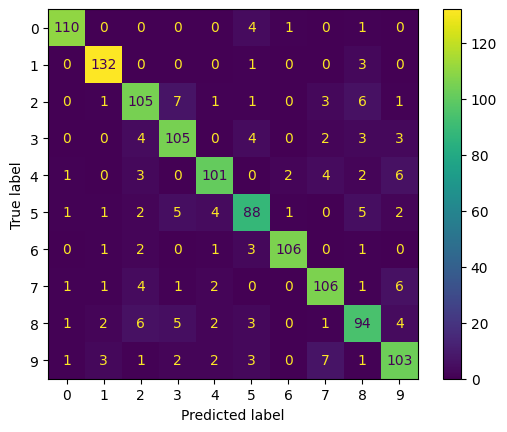

In [22]:
ConfusionMatrixDisplay(cm_logReg, display_labels=range(10)).plot()

### Logistic Regression (with L1 Regularization)

In [23]:
# N = 100
eps = 1e-4
C_list = np.logspace(-3, 2, 6)
best_model = []
best_accuracy = 0
for c_value in C_list:
	logisticReg = LogisticRegression(penalty='l1', solver='saga', max_iter=2000, random_state=random_state, C=c_value)
	logisticReg.fit(X_train, y_train)
	Y_pred,accuracy,cm = test_model(logisticReg, X_val, y_val)
	if accuracy>best_accuracy +eps:
		best_accuracy=accuracy
		best_model = [Y_pred,accuracy,cm,c_value]
print("Accuracy of best model: ",best_model[1])
print("C value of best model: ",best_model[3])

[2025-10-22 14:05:12.782] [CUML] [warning] QWL-QN: max iterations reached
[2025-10-22 14:05:12.782] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-10-22 14:05:24.695] [CUML] [warning] QWL-QN: max iterations reached
[2025-10-22 14:05:24.697] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
Accuracy of best model:  0.885286783042394
C value of best model:  1.0


In [24]:
print("Accuracy of logistic regression with L1 regularization: ", best_model[1])
print(classification_report(y_val, best_model[0], target_names=[str(i) for i in range(10)]))

Accuracy of logistic regression with L1 regularization:  0.885286783042394
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       116
           1       0.92      0.96      0.94       136
           2       0.87      0.88      0.87       125
           3       0.84      0.88      0.86       121
           4       0.93      0.90      0.91       119
           5       0.84      0.80      0.82       109
           6       0.96      0.95      0.95       114
           7       0.88      0.88      0.88       122
           8       0.78      0.78      0.78       118
           9       0.88      0.86      0.87       123

    accuracy                           0.89      1203
   macro avg       0.89      0.88      0.88      1203
weighted avg       0.89      0.89      0.89      1203



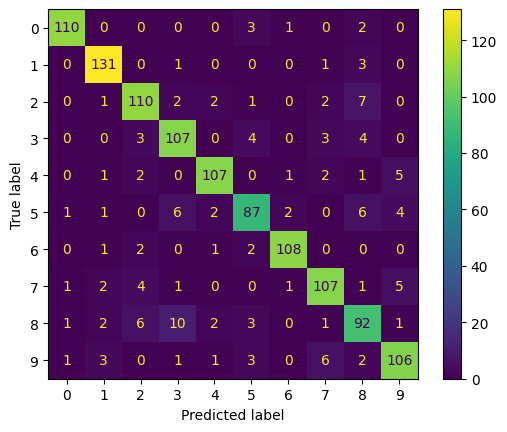

In [25]:
ConfusionMatrixDisplay(best_model[2], display_labels=range(10)).plot()

In [26]:
n_nonzero_logReg_l1 = np.sum(logisticReg_l1.coef_ != 0)
sparsity_ratio_logReg_l1 = n_nonzero_logReg_l1 / logisticReg_l1.coef_.size
print(f"Number of non-zero coefficients in Logistic Regression with L1 regularization: {n_nonzero_logReg_l1}")
print(f"Sparsity ratio in Logistic Regression with L1 regularization: {sparsity_ratio_logReg_l1:.4f}")

NameError: name 'logisticReg_l1' is not defined

### Linear Support Vector Machine

In [27]:
linear_svc = LinearSVC(
    C = 1.0,
    penalty = 'l2',
    dual = False,
    max_iter = 5000,
    random_state = 42,
    verbose = 1
)
linear_svc.fit(X_train, y_train)
y_pred_linSVC, accuracy_linSVC, cm_linSVC = test_model(linear_svc, X_val, y_val)

In [28]:
print("Accuracy of linear support vector machine: ", accuracy_linSVC)
print(classification_report(y_val, y_pred_linSVC, target_names=[str(i) for i in range(10)]))

Accuracy of linear support vector machine:  0.8736492103075644
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       116
           1       0.94      0.97      0.95       136
           2       0.88      0.82      0.85       125
           3       0.81      0.89      0.85       121
           4       0.91      0.87      0.89       119
           5       0.85      0.81      0.83       109
           6       0.95      0.92      0.93       114
           7       0.84      0.89      0.87       122
           8       0.78      0.77      0.78       118
           9       0.83      0.80      0.82       123

    accuracy                           0.87      1203
   macro avg       0.87      0.87      0.87      1203
weighted avg       0.87      0.87      0.87      1203



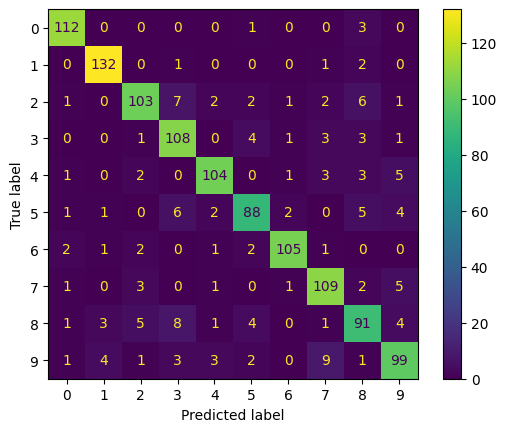

In [29]:
ConfusionMatrixDisplay(cm_linSVC, display_labels=range(10)).plot()

### Random Forest

In [30]:
randomForest = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features='sqrt')
randomForest.fit(X_train,y_train)
y_pred_rf, accuracy_rf, cm_rf = test_model(randomForest, X_val, y_val)

In [31]:
print("Accuracy of random forest classifier: ", accuracy_rf)
print(classification_report(y_val, y_pred_rf, target_names=[str(i) for i in range(10)]))

Accuracy of random forest classifier:  0.940980881130507
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       116
           1       0.93      0.99      0.96       136
           2       0.94      0.96      0.95       125
           3       0.91      0.89      0.90       121
           4       0.93      0.94      0.94       119
           5       0.93      0.90      0.92       109
           6       0.99      0.95      0.97       114
           7       0.91      0.93      0.92       122
           8       0.95      0.93      0.94       118
           9       0.95      0.93      0.94       123

    accuracy                           0.94      1203
   macro avg       0.94      0.94      0.94      1203
weighted avg       0.94      0.94      0.94      1203



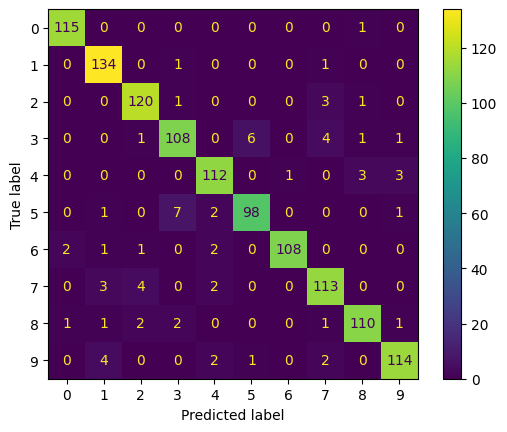

In [32]:
ConfusionMatrixDisplay(cm_rf, display_labels=range(10)).plot()

### Multi-Layer Perceptron (Fully Connected Neural Network)

In [33]:
mlp = MLPClassifier(
    hidden_layer_sizes=(256,128),
    activation='relu',
    solver='adam',
    alpha = 1e-4,
    batch_size = 64,
    learning_rate_init = 1e-3,
    max_iter = 50,
    random_state = 42,
    verbose = True
)
mlp.fit(X_train,y_train)
y_pred_mlp, accuracy_mlp, cm_mlp = test_model(mlp,X_val,y_val)

Iteration 1, loss = 0.67187637
Iteration 2, loss = 0.25543115
Iteration 3, loss = 0.16254621
Iteration 4, loss = 0.11002793
Iteration 5, loss = 0.07353734
Iteration 6, loss = 0.04804531
Iteration 7, loss = 0.02629251
Iteration 8, loss = 0.01785178
Iteration 9, loss = 0.01171103
Iteration 10, loss = 0.00709025
Iteration 11, loss = 0.00623146
Iteration 12, loss = 0.00438060
Iteration 13, loss = 0.00351196
Iteration 14, loss = 0.00295613
Iteration 15, loss = 0.00258216
Iteration 16, loss = 0.00224523
Iteration 17, loss = 0.00198668
Iteration 18, loss = 0.00183930
Iteration 19, loss = 0.00169018
Iteration 20, loss = 0.00156173
Iteration 21, loss = 0.00146037
Iteration 22, loss = 0.00135043
Iteration 23, loss = 0.00127811
Iteration 24, loss = 0.00120911
Iteration 25, loss = 0.00115441
Iteration 26, loss = 0.00109395
Iteration 27, loss = 0.00105266
Iteration 28, loss = 0.00101327
Iteration 29, loss = 0.00097806
Iteration 30, loss = 0.00094355
Iteration 31, loss = 0.00091433
Iteration 32, los

In [34]:
print("Accuracy of fully connected neural network: ", accuracy_mlp)
print(classification_report(y_val, y_pred_mlp, target_names=[str(i) for i in range(10)]))

Accuracy of fully connected neural network:  0.9567747298420615
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       116
           1       0.96      0.99      0.97       136
           2       0.95      0.95      0.95       125
           3       0.96      0.94      0.95       121
           4       0.97      0.95      0.96       119
           5       0.97      0.94      0.95       109
           6       0.99      0.96      0.98       114
           7       0.91      0.96      0.94       122
           8       0.93      0.94      0.94       118
           9       0.95      0.94      0.95       123

    accuracy                           0.96      1203
   macro avg       0.96      0.96      0.96      1203
weighted avg       0.96      0.96      0.96      1203



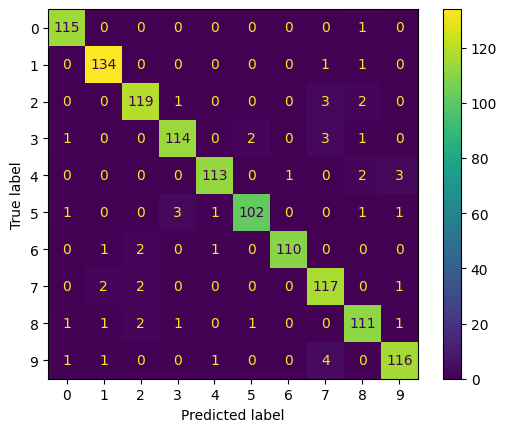

In [35]:
ConfusionMatrixDisplay(cm_mlp, display_labels=range(10)).plot()

## Model Testing (All Features)
Based on validation, two models with best accuracy: MLP and Random Forest

In [ ]:
y_pred_rf_test, accuracy_rf_test, cm_rf_test = test_model(randomForest, X_test, y_test)


## Model Training (using Randomized Sampling)
Checking how random selection of 100 features impacts classification accuracy

In [36]:
random_features = select_features_random(random_state=random_state, n_features=100)
X_train_rnd_100, X_val_rnd_100, X_test_rnd_100 = apply_feature_selection(X_train, X_val, X_test, random_features)

Randomly selected 100 features
Applied feature selection. New feature dimension: 100


### Logistic Regression (No Penalty)

In [37]:
logisticReg.fit(X_train_rnd_100, y_train)
y_pred_logReg_rnd_100, accuracy_logReg_rnd_100, cm_logReg_rnd_100 = test_model(logisticReg, X_val_rnd_100, y_val)

In [38]:
print("Accuracy of logistic regression without regularization: ", accuracy_logReg_rnd_100)
print(classification_report(y_val, y_pred_logReg_rnd_100, target_names=[str(i) for i in range(10)]))

Accuracy of logistic regression without regularization:  0.8536990856192851
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       116
           1       0.92      0.96      0.94       136
           2       0.81      0.82      0.82       125
           3       0.76      0.82      0.79       121
           4       0.86      0.86      0.86       119
           5       0.74      0.69      0.71       109
           6       0.91      0.86      0.88       114
           7       0.88      0.91      0.90       122
           8       0.79      0.77      0.78       118
           9       0.89      0.88      0.89       123

    accuracy                           0.85      1203
   macro avg       0.85      0.85      0.85      1203
weighted avg       0.85      0.85      0.85      1203



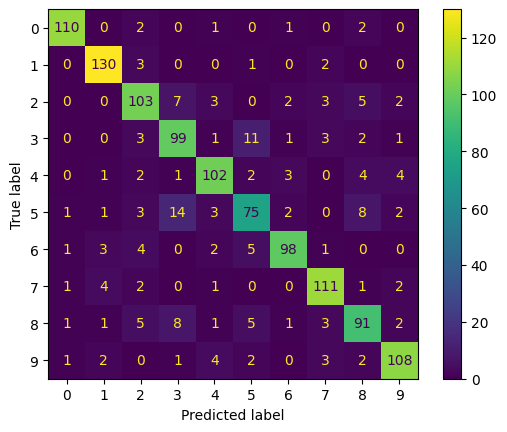

In [39]:
ConfusionMatrixDisplay(cm_logReg_rnd_100, display_labels=range(10)).plot()

### Logistic Regression (with L1 Regularization)

In [40]:
best_model_rnd_100 = []
best_accuracy_rnd_100 = 0
for c_value in C_list:
	logisticReg_rnd_100 = LogisticRegression(penalty='l1', solver='saga', max_iter=2000, random_state=random_state, C=c_value)
	logisticReg_rnd_100.fit(X_train_rnd_100, y_train)
	Y_pred,accuracy,cm = test_model(logisticReg_rnd_100, X_val_rnd_100, y_val)
	if accuracy>best_accuracy_rnd_100 +eps:
		best_accuracy_rnd_100=accuracy
		best_model_rnd_100 = [Y_pred,accuracy,cm,c_value]
print("Accuracy of best model: ",best_model_rnd_100[1])
print("C value of best model: ",best_model_rnd_100[3])

Accuracy of best model:  0.8595178719866999
C value of best model:  1.0


In [41]:
print("Accuracy of logistic regression with L1 regularization: ", best_model_rnd_100[1])
print(classification_report(y_val, best_model_rnd_100[0], target_names=[str(i) for i in range(10)]))

Accuracy of logistic regression with L1 regularization:  0.8595178719866999
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       116
           1       0.91      0.94      0.92       136
           2       0.84      0.87      0.86       125
           3       0.78      0.81      0.79       121
           4       0.88      0.87      0.87       119
           5       0.75      0.71      0.73       109
           6       0.94      0.89      0.91       114
           7       0.86      0.90      0.88       122
           8       0.79      0.78      0.78       118
           9       0.91      0.85      0.88       123

    accuracy                           0.86      1203
   macro avg       0.86      0.86      0.86      1203
weighted avg       0.86      0.86      0.86      1203



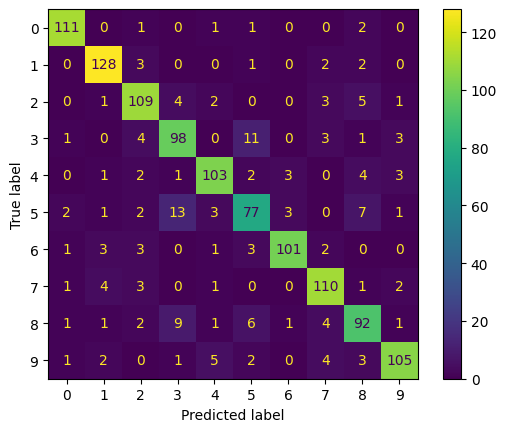

In [42]:
ConfusionMatrixDisplay(best_model_rnd_100[2], display_labels=range(10)).plot()

### Linear Support Vector Machine

In [43]:
linear_svc.fit(X_train_rnd_100, y_train)
y_pred_linSVC_rnd_100, accuracy_linSVC_rnd_100, cm_linSVC_rnd_100 = test_model(linear_svc, X_val_rnd_100, y_val)

In [44]:
print("Accuracy of linear support vector machine: ", accuracy_linSVC_rnd_100)
print(classification_report(y_val, y_pred_linSVC_rnd_100, target_names=[str(i) for i in range(10)]))

Accuracy of linear support vector machine:  0.8478802992518704
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       116
           1       0.90      0.96      0.93       136
           2       0.85      0.87      0.86       125
           3       0.78      0.80      0.79       121
           4       0.85      0.86      0.85       119
           5       0.74      0.69      0.71       109
           6       0.89      0.87      0.88       114
           7       0.85      0.90      0.87       122
           8       0.80      0.75      0.78       118
           9       0.87      0.79      0.83       123

    accuracy                           0.85      1203
   macro avg       0.85      0.85      0.84      1203
weighted avg       0.85      0.85      0.85      1203



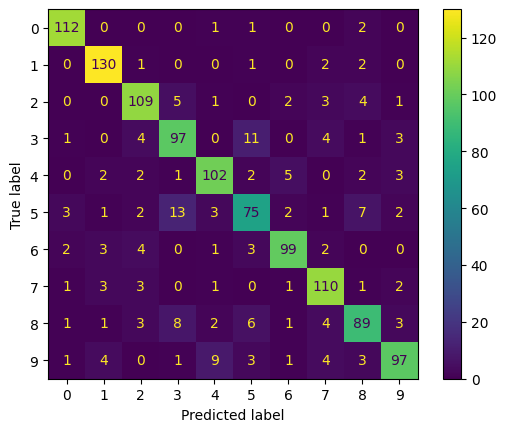

In [45]:
ConfusionMatrixDisplay(cm_linSVC_rnd_100, display_labels=range(10)).plot()

### Random Forest

In [46]:
randomForest.fit(X_train_rnd_100,y_train)
y_pred_rf_rnd_100, accuracy_rf_rnd_100, cm_rf_rnd_100 = test_model(randomForest, X_val_rnd_100, y_val)

In [47]:
print("Accuracy of random forest classifier: ", accuracy_rf_rnd_100)
print(classification_report(y_val, y_pred_rf_rnd_100, target_names=[str(i) for i in range(10)]))

Accuracy of random forest classifier:  0.912718204488778
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       116
           1       0.97      0.98      0.97       136
           2       0.90      0.92      0.91       125
           3       0.84      0.88      0.86       121
           4       0.93      0.96      0.95       119
           5       0.95      0.75      0.84       109
           6       0.92      0.94      0.93       114
           7       0.90      0.92      0.91       122
           8       0.90      0.88      0.89       118
           9       0.89      0.92      0.90       123

    accuracy                           0.91      1203
   macro avg       0.91      0.91      0.91      1203
weighted avg       0.91      0.91      0.91      1203



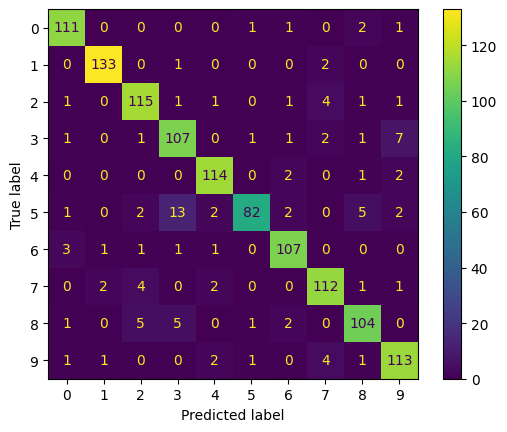

In [48]:
ConfusionMatrixDisplay(cm_rf_rnd_100, display_labels=range(10)).plot()

### Multi-Layer Perceptron (Fully Connected Neural Network)

In [49]:
mlp.fit(X_train_rnd_100,y_train)
y_pred_mlp_rnd_100, accuracy_mlp_rnd_100, cm_mlp_rnd_100 = test_model(mlp,X_val_rnd_100,y_val)

Iteration 1, loss = 1.13050926
Iteration 2, loss = 0.52247431
Iteration 3, loss = 0.41981724
Iteration 4, loss = 0.36117062
Iteration 5, loss = 0.31563201
Iteration 6, loss = 0.27607170
Iteration 7, loss = 0.25024775
Iteration 8, loss = 0.22653563
Iteration 9, loss = 0.20112534
Iteration 10, loss = 0.18746660
Iteration 11, loss = 0.16107499
Iteration 12, loss = 0.14685548
Iteration 13, loss = 0.12944907
Iteration 14, loss = 0.12360600
Iteration 15, loss = 0.11016115
Iteration 16, loss = 0.09798429
Iteration 17, loss = 0.08718595
Iteration 18, loss = 0.07724960
Iteration 19, loss = 0.07424839
Iteration 20, loss = 0.06179110
Iteration 21, loss = 0.05858560
Iteration 22, loss = 0.05236334
Iteration 23, loss = 0.04755192
Iteration 24, loss = 0.03819444
Iteration 25, loss = 0.03618573
Iteration 26, loss = 0.03025161
Iteration 27, loss = 0.02962905
Iteration 28, loss = 0.02462807
Iteration 29, loss = 0.02158238
Iteration 30, loss = 0.01758153
Iteration 31, loss = 0.01537948
Iteration 32, los

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [50]:
print("Accuracy of fully connected neural network: ", accuracy_mlp_rnd_100)
print(classification_report(y_val, y_pred_mlp_rnd_100, target_names=[str(i) for i in range(10)]))

Accuracy of fully connected neural network:  0.9310058187863675
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       116
           1       0.94      0.99      0.96       136
           2       0.89      0.97      0.93       125
           3       0.92      0.93      0.92       121
           4       0.97      0.95      0.96       119
           5       0.94      0.85      0.89       109
           6       0.96      0.94      0.95       114
           7       0.92      0.93      0.92       122
           8       0.88      0.88      0.88       118
           9       0.93      0.91      0.92       123

    accuracy                           0.93      1203
   macro avg       0.93      0.93      0.93      1203
weighted avg       0.93      0.93      0.93      1203



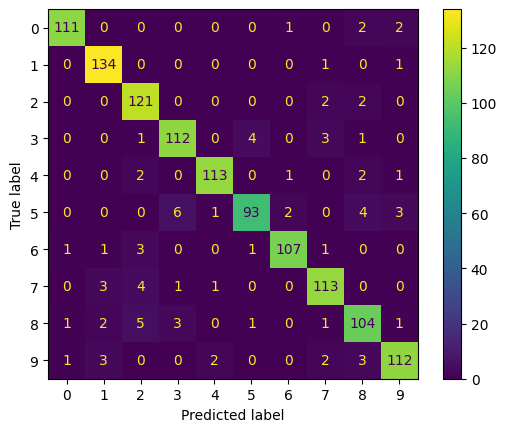

In [51]:
ConfusionMatrixDisplay(cm_mlp_rnd_100, display_labels=range(10)).plot()

## Model Training (using Variance-Based Sampling)
Checking how selection of 100 features based on variance affects classification accuracy.

In [52]:
high_variance_features = select_features_variance(X_train, n_features=100)
X_train_var_100, X_val_var_100, X_test_var_100 = apply_feature_selection(X_train, X_val, X_test, high_variance_features)

Selected top 100 features by variance
Applied feature selection. New feature dimension: 100


### Logistic Regression (No Penalty)

In [53]:
logisticReg.fit(X_train_var_100, y_train)
y_pred_logReg_var_100, accuracy_logReg_var_100, cm_logReg_var_100 = test_model(logisticReg, X_val_var_100, y_val)

In [54]:
print("Accuracy of logistic regression without regularization: ", accuracy_logReg_var_100)
print(classification_report(y_val, y_pred_logReg_var_100, target_names=[str(i) for i in range(10)]))

Accuracy of logistic regression without regularization:  0.7980049875311721
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       116
           1       0.90      0.94      0.92       136
           2       0.74      0.73      0.73       125
           3       0.76      0.79      0.77       121
           4       0.81      0.81      0.81       119
           5       0.69      0.70      0.69       109
           6       0.88      0.87      0.87       114
           7       0.74      0.78      0.76       122
           8       0.78      0.69      0.74       118
           9       0.76      0.74      0.75       123

    accuracy                           0.80      1203
   macro avg       0.80      0.80      0.80      1203
weighted avg       0.80      0.80      0.80      1203



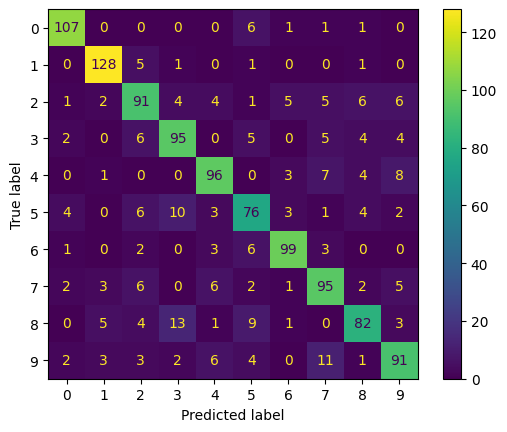

In [55]:
ConfusionMatrixDisplay(cm_logReg_var_100, display_labels=range(10)).plot()

### Logistic Regression (with L1 Regularization)

In [56]:
best_model_var_100 = []
best_accuracy_var_100 = 0
for c_value in C_list:
	logisticReg_var_100 = LogisticRegression(penalty='l1', solver='saga', max_iter=2000, random_state=random_state, C=c_value)
	logisticReg_var_100.fit(X_train_var_100, y_train)
	Y_pred,accuracy,cm = test_model(logisticReg_var_100, X_val_var_100, y_val)
	if accuracy>best_accuracy_var_100 +eps:
		best_accuracy_var_100=accuracy
		best_model_var_100 = [Y_pred,accuracy,cm,c_value]
print("Accuracy of best model: ",best_model_var_100[1])
print("C value of best model: ",best_model_var_100[3])

[2025-10-22 14:09:15.713] [CUML] [warning] QWL-QN: max iterations reached
[2025-10-22 14:09:15.713] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
Accuracy of best model:  0.8079800498753117
C value of best model:  1.0


In [57]:
print("Accuracy of logistic regression with L1 regularization: ", best_model_var_100[1])
print(classification_report(y_val, best_model_var_100[0], target_names=[str(i) for i in range(10)]))

Accuracy of logistic regression with L1 regularization:  0.8079800498753117
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       116
           1       0.92      0.96      0.94       136
           2       0.77      0.72      0.74       125
           3       0.74      0.79      0.77       121
           4       0.80      0.82      0.81       119
           5       0.73      0.70      0.71       109
           6       0.88      0.88      0.88       114
           7       0.76      0.79      0.77       122
           8       0.77      0.72      0.75       118
           9       0.78      0.74      0.76       123

    accuracy                           0.81      1203
   macro avg       0.81      0.81      0.81      1203
weighted avg       0.81      0.81      0.81      1203



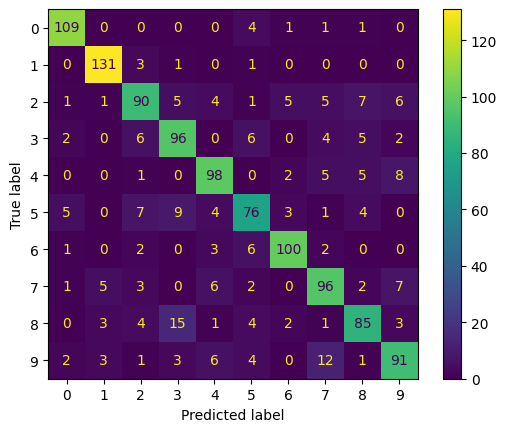

In [64]:
ConfusionMatrixDisplay(best_model_var_100[2], display_labels=range(10)).plot()

## Linear Support Vector Machine

In [58]:
linear_svc.fit(X_train_var_100, y_train)
y_pred_linSVC_var_100, accuracy_linSVC_var_100, cm_linSVC_var_100 = test_model(linear_svc, X_val_var_100, y_val)

In [59]:
print("Accuracy of linear support vector machine: ", accuracy_linSVC_var_100)
print(classification_report(y_val, y_pred_linSVC_var_100, target_names=[str(i) for i in range(10)]))

Accuracy of linear support vector machine:  0.7930174563591023
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       116
           1       0.92      0.96      0.94       136
           2       0.77      0.71      0.74       125
           3       0.70      0.80      0.75       121
           4       0.80      0.83      0.81       119
           5       0.76      0.53      0.63       109
           6       0.88      0.89      0.89       114
           7       0.73      0.82      0.77       122
           8       0.75      0.69      0.72       118
           9       0.70      0.71      0.70       123

    accuracy                           0.79      1203
   macro avg       0.79      0.79      0.79      1203
weighted avg       0.79      0.79      0.79      1203



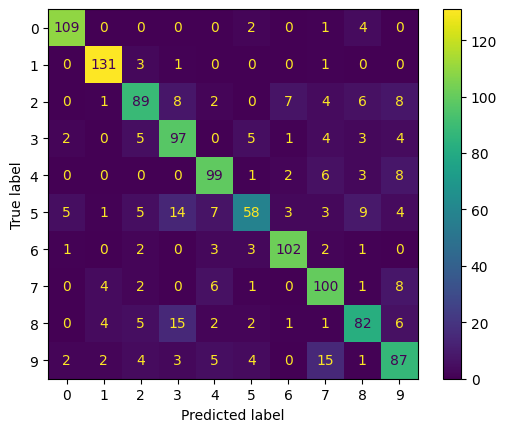

In [63]:
ConfusionMatrixDisplay(cm_linSVC_var_100, display_labels=range(10)).plot()

### Random Forest

In [61]:
randomForest.fit(X_train_var_100,y_train)
y_pred_rf_var_100, accuracy_rf_var_100, cm_rf_var_100 = test_model(randomForest, X_val_var_100, y_val)

In [62]:
print("Accuracy of random forest classifier: ", accuracy_rf_var_100)
print(classification_report(y_val, y_pred_rf_var_100, target_names=[str(i) for i in range(10)]))

Accuracy of random forest classifier:  0.8861180382377389
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       116
           1       0.93      0.99      0.96       136
           2       0.88      0.90      0.89       125
           3       0.78      0.81      0.79       121
           4       0.92      0.92      0.92       119
           5       0.79      0.87      0.83       109
           6       0.95      0.87      0.91       114
           7       0.88      0.87      0.87       122
           8       0.87      0.78      0.82       118
           9       0.92      0.88      0.90       123

    accuracy                           0.89      1203
   macro avg       0.89      0.88      0.88      1203
weighted avg       0.89      0.89      0.89      1203



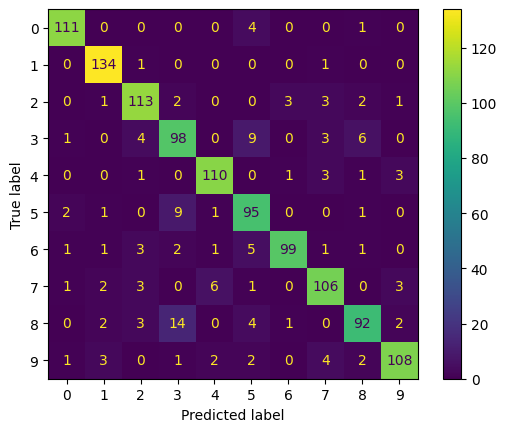

In [65]:
ConfusionMatrixDisplay(cm_rf_var_100, display_labels=range(10)).plot()

### Multi-Layer Perceptron (Fully Connected Neural Network)

In [66]:
mlp.fit(X_train_var_100,y_train)
y_pred_mlp_var_100, accuracy_mlp_var_100, cm_mlp_var_100 = test_model(mlp,X_val_var_100,y_val)

Iteration 1, loss = 1.07461731
Iteration 2, loss = 0.56755598
Iteration 3, loss = 0.46201793
Iteration 4, loss = 0.39205892
Iteration 5, loss = 0.33631777
Iteration 6, loss = 0.28938604
Iteration 7, loss = 0.25947151
Iteration 8, loss = 0.23654606
Iteration 9, loss = 0.20434619
Iteration 10, loss = 0.18569659
Iteration 11, loss = 0.15698370
Iteration 12, loss = 0.14650085
Iteration 13, loss = 0.12299811
Iteration 14, loss = 0.11334127
Iteration 15, loss = 0.09653365
Iteration 16, loss = 0.08280264
Iteration 17, loss = 0.07410388
Iteration 18, loss = 0.06115648
Iteration 19, loss = 0.05256291
Iteration 20, loss = 0.04259244
Iteration 21, loss = 0.03670308
Iteration 22, loss = 0.03440542
Iteration 23, loss = 0.02831749
Iteration 24, loss = 0.03163056
Iteration 25, loss = 0.02889119
Iteration 26, loss = 0.02230543
Iteration 27, loss = 0.01622656
Iteration 28, loss = 0.01196396
Iteration 29, loss = 0.01033962
Iteration 30, loss = 0.00866773
Iteration 31, loss = 0.00768967
Iteration 32, los

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [67]:
print("Accuracy of fully connected neural network: ", accuracy_mlp_var_100)
print(classification_report(y_val, y_pred_mlp_var_100, target_names=[str(i) for i in range(10)]))

Accuracy of fully connected neural network:  0.9102244389027432
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       116
           1       0.96      0.99      0.97       136
           2       0.91      0.92      0.91       125
           3       0.83      0.89      0.86       121
           4       0.93      0.91      0.92       119
           5       0.90      0.87      0.89       109
           6       0.94      0.90      0.92       114
           7       0.87      0.92      0.89       122
           8       0.88      0.82      0.85       118
           9       0.93      0.90      0.92       123

    accuracy                           0.91      1203
   macro avg       0.91      0.91      0.91      1203
weighted avg       0.91      0.91      0.91      1203



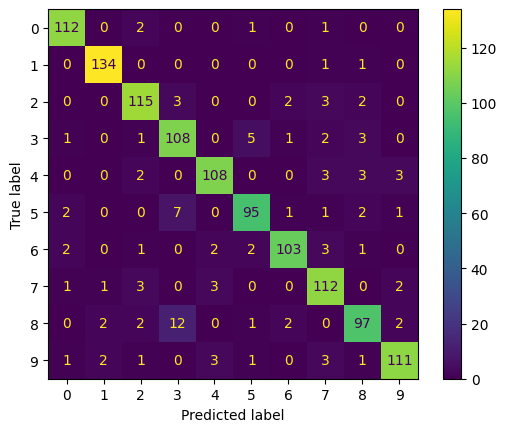

In [68]:
ConfusionMatrixDisplay(cm_mlp_var_100, display_labels=range(10)).plot()